This is the Code that Traines the DCGAN model, this was train with a GPU. The model design is based off of these two sources:
1) https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
2) https://github.com/pytorch/examples/issues/70

In [ ]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

V5L1 =np.load('/content/drive/My Drive/GAN_training_data/volc5lava1.npy')
V4L1 =np.load('/content/drive/My Drive/GAN_training_data/volc4lava1.npy')
V5L2 =np.load('/content/drive/My Drive/GAN_training_data/volc5lava2.npy')
V3L1 =np.load('/content/drive/My Drive/GAN_training_data/volc3lava1.npy')

Mounted at /content/drive


In [ ]:
#combining the arrays
training_set =np.concatenate((V5L1,V5L2,V4L1,V3L1), axis=0).astype(np.float32)
training_set = np.expand_dims(training_set, axis=1)
print(training_set.shape)

(846, 1, 128, 128)


In [ ]:
#the hyper parameters
image_size=128
nc=1 #no. of colour channels
nz = 100 #the size of the generators input
num_epochs=20
lr = 0.0002
beta1 = 0.5 #needed for adam optimizer
ngpu = 1 #saying there is one gpu available
ngf=128 #should be to do with the depth of the feature map, just copied the value from the origional
ndf=32 #same as above
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
bs=47

The Data Loader

In [ ]:
class NumpyImageDataset(Dataset):
    def __init__(self, numpy_array, transform=None):
        """
        Args:
            numpy_array (np.ndarray): Array of shape (num_samples, channels, height, width)
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = torch.tensor(numpy_array, dtype=torch.float32)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

transform = transforms.Compose([
    transforms.Normalize(mean=(0.5,), std=(0.5,))])
# Create DataLoader
dataloader = DataLoader(training_set, batch_size=bs, shuffle=True, num_workers=4)

# Check data shapes
for i, data in enumerate(dataloader, 0):
    print(f"Data shape from DataLoader: {data.shape}")  # Should print [18, 1, 128, 128]
    break  # Check only the first batch

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Data shape from DataLoader: torch.Size([47, 1, 128, 128])


In [ ]:
# Apply weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),  # Output: (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # Output: (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # Output: (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # Output: (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),  # Output: (1, 64, 64)
            nn.BatchNorm2d(1),
            nn.ReLU(True),
            nn.ConvTranspose2d(1, 1, 4, 2, 1, bias=False),  # Output: (1, 128, 128)
            nn.Tanh()
        )

    def forward(self, input):
        x = input
        for layer in self.main:
            x = layer(x)

        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Create the generator
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(1, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(1, 

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),  # From 3 to 1 input channel
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        )
        self.fc = nn.Sequential(
            nn.Linear(5*5*1, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        x = self.main(input)
        x = x.view(-1, 5*5*1)  # Flatten the tensor
        return self.fc(x)

In [ ]:
netD = Discriminator().to(device)

netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=25, 

In [ ]:
nc = 1  # Number of channels in images

# Test with dummy input
dummy_input = torch.randn(1,nz,1,1)  # Latent vector for Generator
netG = Generator(nz).to(device)
generated_image =netG(dummy_input)
print('Generated image shape:', generated_image.shape)

dummy_image = torch.randn(1, nc, 128, 128)  # Dummy image for Discriminator
discriminator_output = netD(dummy_image)
print('Discriminator output shape:', discriminator_output.shape)

Generated image shape: torch.Size([1, 1, 128, 128])
Discriminator output shape: torch.Size([1, 1])


In [ ]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(bs,nz,1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
fixed_noise.shape

torch.Size([47, 100, 1, 1])

In [ ]:
lambda_gp = 10  # Gradient penalty lambda hyperparameter
img_list = []
G_losses = []
D_losses = []
iters = 10

def gradient_penalty(discriminator, real_data, fake_data):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolated_data = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated_data.requires_grad_(True)

    d_interpolated = discriminator(interpolated_data)

    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated_data,
        grad_outputs=torch.ones(d_interpolated.size()).to(device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()

    return gradient_penalty

# Training loop
num_epochs = 40
n_critic = 5  # Number of discriminator updates per generator update

# for epoch in range(num_epochs):
#     for i, data in enumerate(dataloader, 0):
#         ############################
#         # (1) Update D network
#         ###########################
#         netD.zero_grad()
#         real_data = data.to(device)
#         b_size = real_data.size(0)

#         #noise = torch.randn(bs, nz, 1, 1, device=device)
#         fake_data = netG(fixed_noise)
#         d_real = netD(real_data).view(-1)
#         d_fake = netD(fake_data.detach()).view(-1)

#         gradient_pen = gradient_penalty(netD, real_data, fake_data)
#         d_loss = d_fake.mean() - d_real.mean() + lambda_gp * gradient_pen
#         d_loss.backward()
#         optimizerD.step()

#         ############################
#         # (2) Update G network
#         ###########################
#         if i % n_critic == 0:  # Update G every n_critic steps
#             netG.zero_grad()
#             g_fake = netD(fake_data).view(-1)
#             g_loss = -g_fake.mean()
#             g_loss.backward()
#             optimizerG.step()

#         # Output training stats
#         if i % 50 == 0:
#             print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {d_loss.item():.4f}\tLoss_G: {g_loss.item():.4f}')

#         # Save Losses for plotting later
#         G_losses.append(g_loss.item())
#         D_losses.append(d_loss.item())

#         # Check how the generator is doing
#         if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
#             with torch.no_grad():
#                 fake = netG(fixed_noise).detach().cpu()
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

#         iters += 1

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        real_data = data.to(device)
        b_size = real_data.size(0)

        ############################
        # (1) Update Discriminator
        ###########################
        netD.zero_grad()
        noise = torch.randn(b_size,nz,1, 1, device=device)
        print(noise.shape)
        fake_data = netG(noise).detach()  # Detach fake data for Discriminator update

        d_real = netD(real_data).view(-1)
        d_fake = netD(fake_data).view(-1)

        d_loss = d_fake.mean() - d_real.mean()
        d_loss.backward()
        optimizerD.step()
        D_losses.append(d_loss.item())

        ############################
        # (2) Update Generator
        ###########################
        if i % n_critic == 0:  # Update Generator every n_critic steps
            netG.zero_grad()
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_data = netG(noise)  # Generate new fake data for Generator update

            g_fake = netD(fake_data).view(-1)
            g_loss = -g_fake.mean()
            g_loss.backward()
            optimizerG.step()
            G_losses.append(g_loss.item())

        # Output training stats
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {d_loss.item():.4f}\tLoss_G: {g_loss.item():.4f}')

torch.Size([47, 100, 1, 1])
[0/100][0/18]	Loss_D: -0.4369	Loss_G: -0.0452
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
[1/100][0/18]	Loss_D: -0.9945	Loss_G: -0.0036
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([47, 100, 1, 1])
torch.Size([

KeyboardInterrupt: 

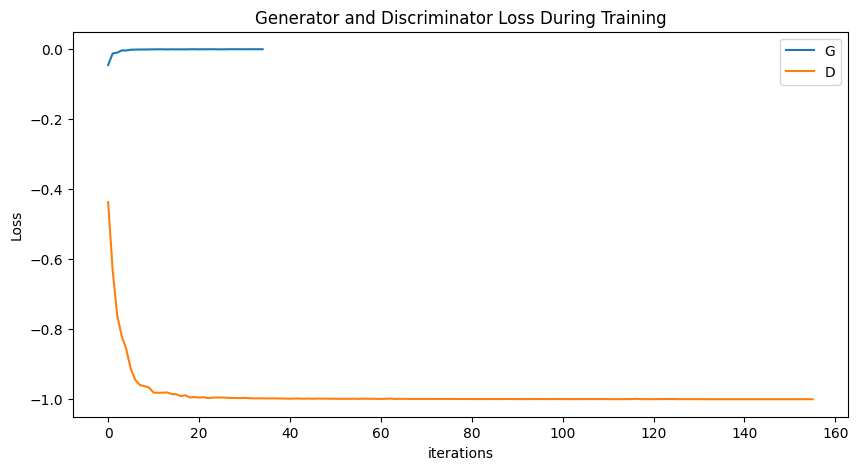

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
torch.save(netG.state_dict(), '/content/drive/My Drive/GAN_training_data/generator_state_dict2.pth')
torch.save(netD.state_dict(), '/content/drive/My Drive/GAN_training_data/discriminator_state_dict2.pth')

In [ ]:
import seaborn as sns
from sklearn.metrics import mean_squared_error
latent_dim = 100  # This should be the same as the one used during training
num_samples = 30  # Number of images you want to generate
noise = torch.randn(num_samples, latent_dim, 1, 1, device=device)

# Generate images
with torch.no_grad():
    generated_images = netG(noise).detach().cpu()

# Post-process the images
generated_images = (generated_images * 0.5 + 0.5)
images =[]
for i, img_tensor in enumerate(generated_images):
    n =np.array(img_tensor)
    kn =n.squeeze()
    images.append(kn)

<Axes: >

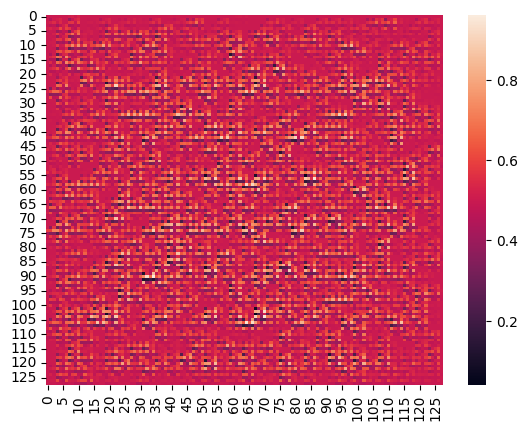

In [ ]:
sns.heatmap(images[12])

In [ ]:
mean_squared_error(images[5],images[13])

0.00688977

In [ ]:
data = np.array([1, 2, 3, 4, 5])

def normalise(data):
  min_val = np.min(data)
  max_val = np.max(data)
  normalized_data = (data - min_val) / (max_val - min_val)

  return normalized_data

<Axes: >

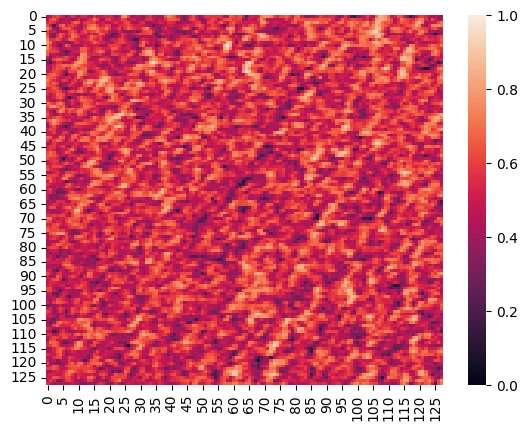

In [ ]:
sns.heatmap(normalise(training_set[7].squeeze()))

<Axes: >

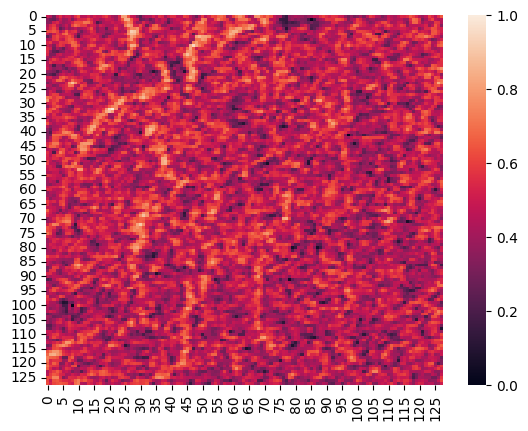

In [ ]:
sns.heatmap(normalise(training_set[26].squeeze()))